In [36]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import plotly.express as px
import pandas as pd

pd.set_option('display.float_format', lambda x: f'{x :.2f}')
from get_dataframes import GetDataframes
import hjson

import matplotlib.pyplot as plt
import explo_data_analysis.eda_movies as eda

with open("config.hjson") as fp:
    config = hjson.load(fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
datas = GetDataframes(config)
link = "actors_movies"
df = datas.get_dataframes(
    link,
)

2023-10-30 15:26:51 INFO     TSV files already exist.
2023-10-30 15:26:51 INFO     Parquet loaded ! Importing actors...
2023-10-30 15:27:16 INFO     Parquet loaded ! Importing persons...
2023-10-30 15:28:02 INFO     Parquet loaded ! Importing movies...
2023-10-30 15:28:59 INFO     Replace tt by movies titles...
2023-10-30 15:29:00 INFO     Writing actors_movies dataframe...
2023-10-30 15:29:02 INFO     Dataframe actors_movies ready to use!


In [39]:
df["person_name"].value_counts()

person_name
Gérard Depardieu        135
John Wayne              108
Catherine Deneuve       102
Michel Piccoli          101
Marcello Mastroianni    100
                       ... 
John Amplas               1
Christine Forrest         1
Elyane Nadeau             1
Sally Erwin               1
Elizabett Conceição       1
Name: count, Length: 83292, dtype: int64

**JME SUIS ARRETÉ LA**


In [40]:
df = df.copy()

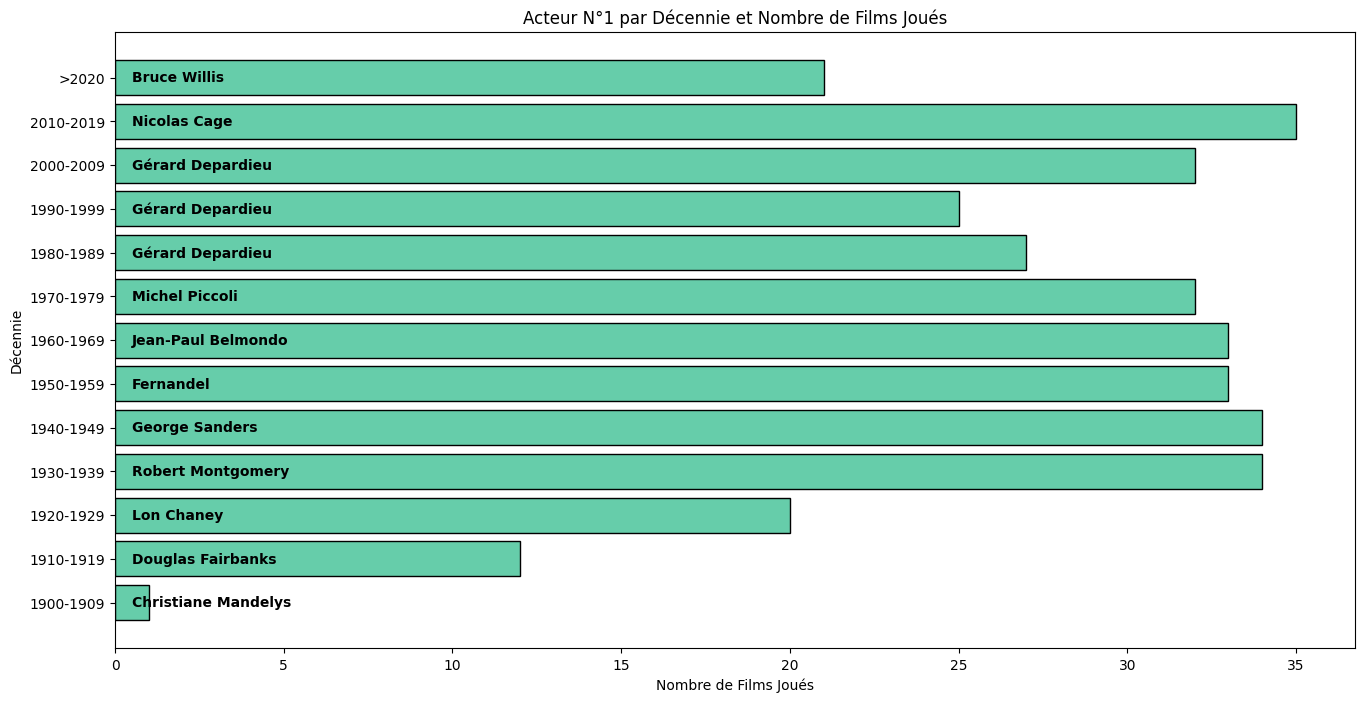

In [41]:
grouped_df = df.groupby(
    ['cuts', 'person_name'],
            observed=True
).size().reset_index(name='total_film_acteurs').sort_values(by="total_film_acteurs")

top_acteurs_decennie = grouped_df.groupby(
    'cuts',
            observed=True
).apply(lambda x: x.nlargest(1, 'total_film_acteurs')).reset_index(drop=True)

decennies = top_acteurs_decennie['cuts']
noms_acteurs = top_acteurs_decennie['person_name']
nombre_films = top_acteurs_decennie['total_film_acteurs']

plt.figure(figsize=(16, 8))
bars = plt.barh(
    decennies,
    nombre_films,
    color='#66cdaa',
    edgecolor="black"
)
for i, (count, name) in enumerate(zip(
    top_acteurs_decennie['total_film_acteurs'],
    top_acteurs_decennie['person_name'])):
    plt.text(0.5, i, name, color='black', va='center', ha='left', fontweight='bold')

plt.title('Acteur N°1 par Décennie et Nombre de Films Joués')
plt.xlabel('Nombre de Films Joués')
plt.ylabel('Décennie')
plt.show()


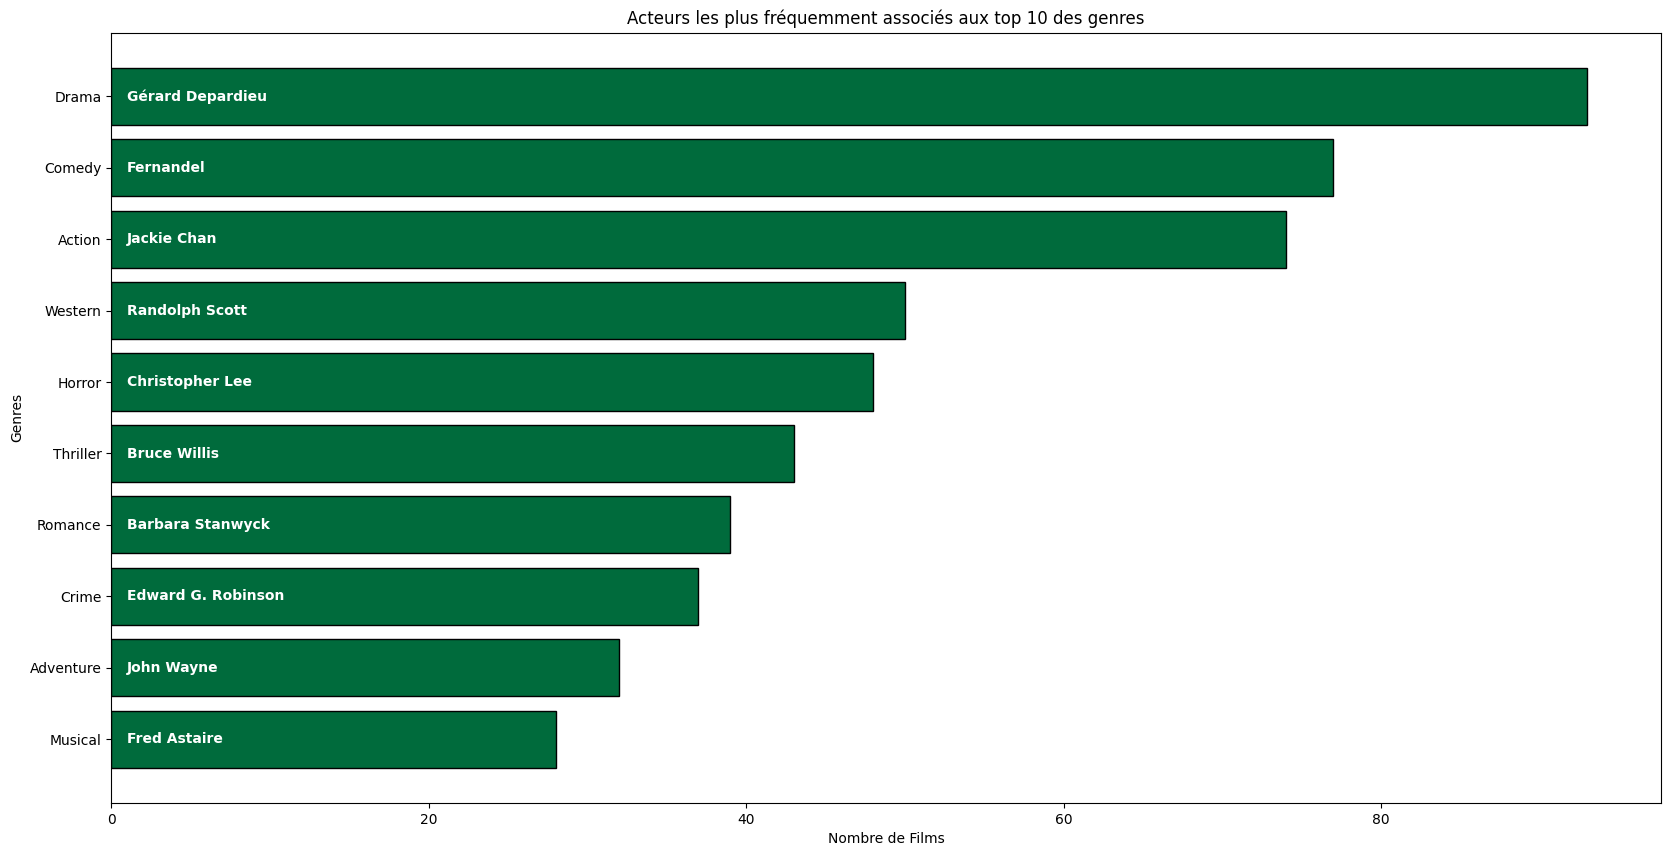

In [42]:
actors_by_genre = df.explode('titre_genres').groupby(['person_name', 'titre_genres']).size().reset_index(name='count')
top_actors_by_genre = actors_by_genre.sort_values('count', ascending=False).drop_duplicates('titre_genres')[:10][::-1]

plt.figure(figsize=(20, 10))
plt.barh(
    top_actors_by_genre['titre_genres'],
    top_actors_by_genre['count'],
    color='#006b3c',
    edgecolor = "black",
)
plt.xlabel('Nombre de Films')
plt.ylabel('Genres')
plt.title('Acteurs les plus fréquemment associés aux top 10 des genres')

for i, (count, name) in enumerate(zip(
    top_actors_by_genre['count'],
    top_actors_by_genre['person_name'])):
    plt.text(1, i, name, color='white', va='center', ha='left', fontweight='bold')


plt.show()


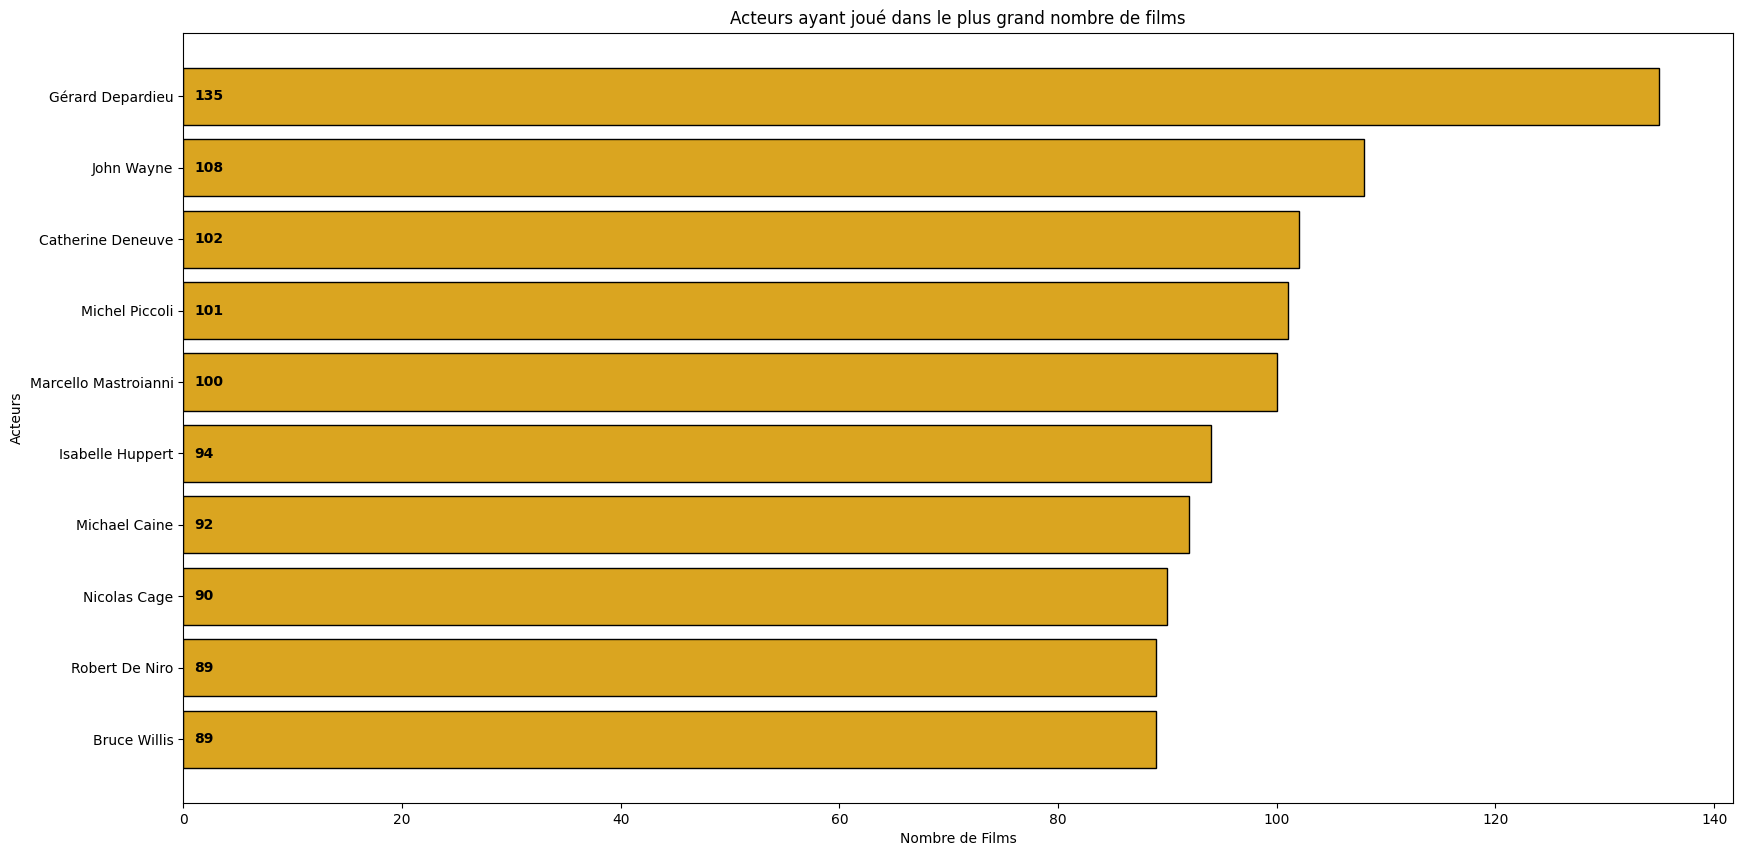

In [43]:
actors_film_count = df.groupby('person_name').size().reset_index(name='film_count')

top_actors_film_count = actors_film_count.sort_values('film_count', ascending=False).head(10)[::-1]

plt.figure(figsize=(20, 10))
plt.barh(
    top_actors_film_count['person_name'],
    top_actors_film_count['film_count'],
    color='#daa520',
    edgecolor="black",
)
for i, (count, name) in enumerate(zip(
    top_actors_film_count['person_name'],
    top_actors_film_count['film_count'])):
    plt.text(1, i, name, color='black', va='center', ha='left', fontweight='bold')

plt.xlabel('Nombre de Films')
plt.ylabel('Acteurs')
plt.title('Acteurs ayant joué dans le plus grand nombre de films')
plt.show()


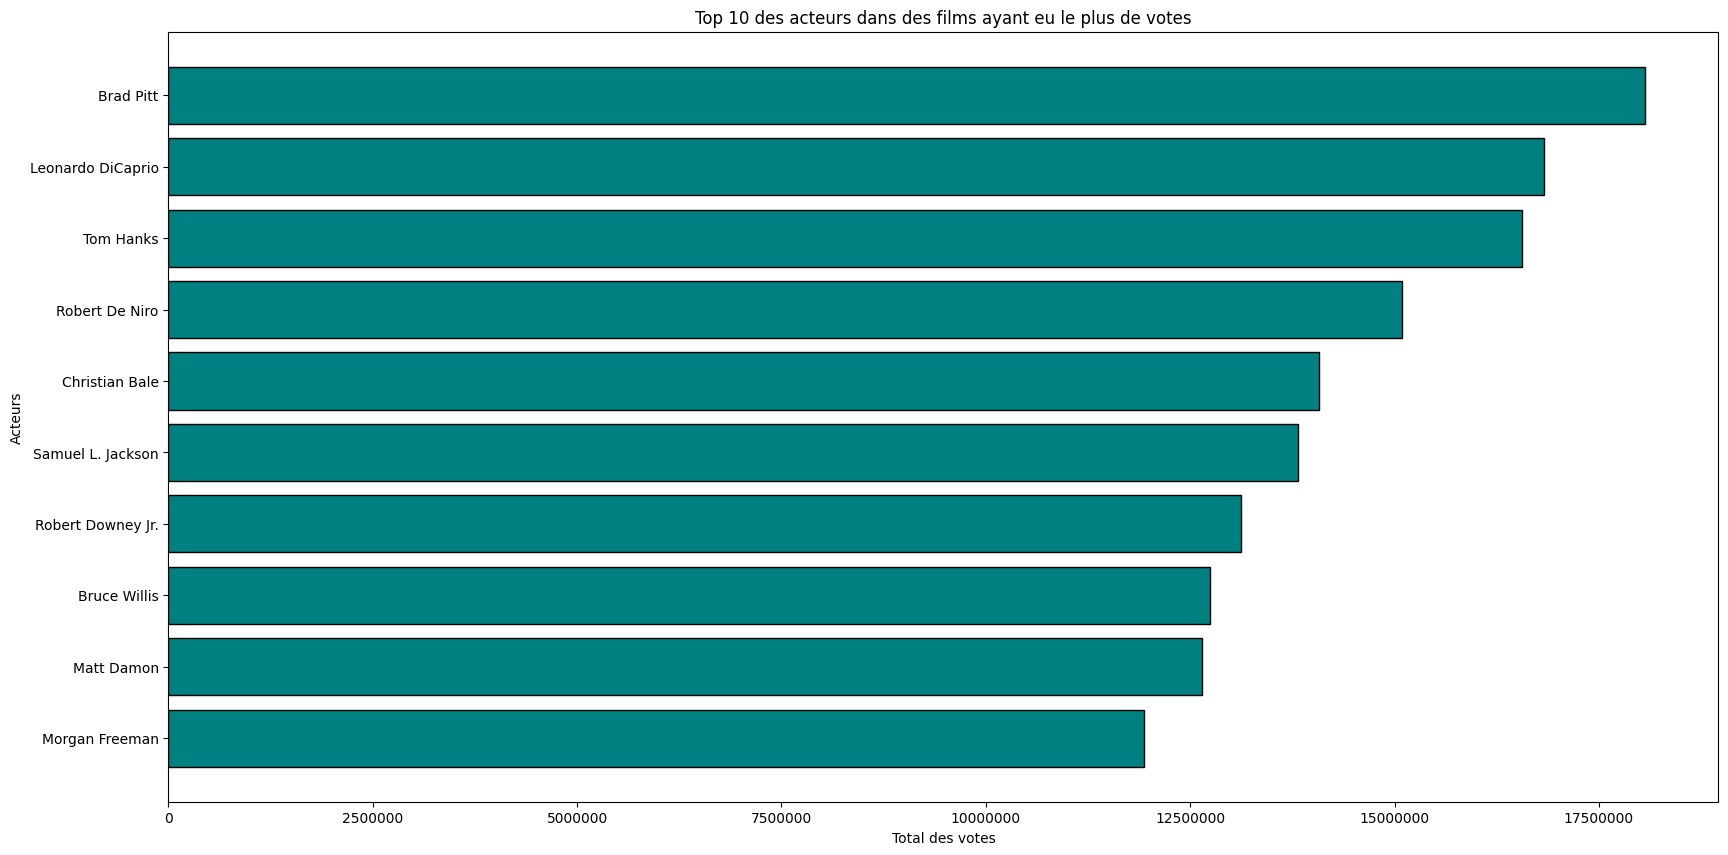

In [44]:
actors_by_votes = df.groupby('person_name')['rating_votes'].sum().reset_index()

top_actors_by_votes = actors_by_votes.sort_values('rating_votes', ascending=False).head(10)[::-1]

plt.figure(figsize=(20, 10))
plt.barh(
    top_actors_by_votes['person_name'],
    top_actors_by_votes['rating_votes'],
    color='#008080',
    edgecolor = "black"
)

plt.xlabel('Total des votes')
plt.ylabel('Acteurs')
plt.title('Top 10 des acteurs dans des films ayant eu le plus de votes')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


In [45]:
df.head()

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,...,status,region,cuts,person_id,person_name,person_birthdate,person_job,person_role,person_film,person_index
0,tt0020403,Show of Shows,1929,128,[Comedy],5.80,462,en,Show of Shows,1.12,...,Released,FR,1920-1929,nm0183823,William Courtenay,1875,actor,[The Minister - Guillotine Sequence],[Show of Shows],2
1,tt0020403,Show of Shows,1929,128,[Comedy],5.80,462,en,Show of Shows,1.12,...,Released,FR,1920-1929,nm0098376,Hobart Bosworth,1867,actor,[Executioner - Guillotine Sequence],[The Big Parade],4
2,tt0020403,Show of Shows,1929,128,[Comedy],5.80,462,en,Show of Shows,1.12,...,Released,FR,1920-1929,nm0912478,H.B. Warner,1876,actor,[The Victim - Guillotine Sequence],"[Mr. Deeds Goes to Town, You Can't Take It wit...",3
3,tt0020403,Show of Shows,1929,128,[Comedy],5.80,462,en,Show of Shows,1.12,...,Released,FR,1920-1929,nm0269567,Frank Fay,1891,actor,[Master of Ceremonies],[Nothing Sacred],1
4,tt0165435,The Arrival from the Darkness,1921,60,"[Fantasy, Horror]",6.40,109,cs,Příchozí z temnot,0.60,...,Released,FR,1920-1929,nm0841389,Josef Sváb-Malostranský,1860,actor,[Jan],[],3


In [47]:
df1 = df.copy()

In [50]:
gerard = df1[df1["person_name"].str.contains("Morgan Freeman")]
# gerard = gerard.copy()
gerard.head()

# on a une problemen, si les films ne sont pas dans la liste initial tconst, alors nous n'avons pas de modification, que faire ?
# remplacer par unknow ? supprimer les tt dans la liste et ne conserver que les films convertie ?

,titre_id,titre_str,titre_date_sortie,titre_duree,titre_genres,rating_avg,rating_votes,original_language,original_title,popularity,...,status,region,cuts,person_id,person_name,person_birthdate,person_job,person_role,person_film,person_index
37623,tt0097239,Driving Miss Daisy,1989,99,"[Comedy, Drama, Romance]",7.30,115340,en,Driving Miss Daisy,11.37,...,Released,FR,1980-1989,nm0000151,Morgan Freeman,1937,actor,[Hoke Colburn],"[The Dark Knight, Million Dollar Baby, Se7en, ...",1
61271,tt0105695,Unforgiven,1992,130,"[Drama, Western]",8.20,427341,en,Unforgiven,23.54,...,Released,FR,1990-1999,nm0000151,Morgan Freeman,1937,actor,[Ned Logan],"[The Dark Knight, Million Dollar Baby, Se7en, ...",3
61333,tt0164212,Under Suspicion,2000,110,"[Crime, Drama, Thriller]",6.40,27073,en,Under Suspicion,10.50,...,Released,FR,2000-2009,nm0000151,Morgan Freeman,1937,actor,[Captain Victor Benezet],"[The Dark Knight, Million Dollar Baby, Se7en, ...",1
71159,tt0405159,Million Dollar Baby,2004,132,"[Drama, Sport]",8.10,708905,en,Million Dollar Baby,22.60,...,Released,FR,2000-2009,nm0000151,Morgan Freeman,1937,actor,[Eddie Scrap-Iron Dupris],"[The Dark Knight, Million Dollar Baby, Se7en, ...",3
71905,tt0825232,The Bucket List,2007,97,"[Adventure, Comedy, Drama]",7.40,255340,en,The Bucket List,20.77,...,Released,FR,2000-2009,nm0000151,Morgan Freeman,1937,actor,[Carter],"[The Dark Knight, Million Dollar Baby, Se7en, ...",2
